# 1. feladat

Implementálj saját spektrogram készítő függvényt. A függvény legyen képes kezelni különböző ablakméretet. Készíts hozzá ábrázoló eljárást is ügyelve az ábra skáláira. Alkalmazd az áljárásod egy tetszőleges adatsorra, például hangminta, és elemezd az ábrá(i)d. 

Nézz utána annak is, milyen könyvtári függvény valósítja meg ezt a feladatot, és készítsd el azzal is az elemzést.

In [123]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['specgram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.0, 'Az adatsor, egy többszörösen bifurkálódott jel')

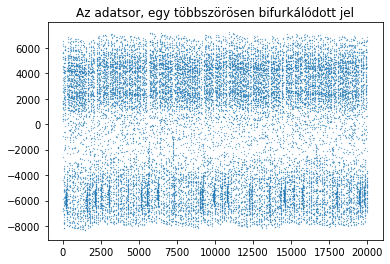

In [164]:
from scipy.io import wavfile
sample_rate, data = wavfile.read('kaosz_meres_minden_lepesek.wav')
data.shape
data=data[1820000:1840000,0]
L=len(data)
plot(data,linewidth=0,marker='.', markersize=0.5)
data.shape
title('Az adatsor, egy többszörösen bifurkálódott jel')
#data=np.linspace(0,len(data),5000)
#data=np.sin(data)
#plot(data)

A direkt Fourier-transzformáció:

In [125]:
def DFT(signal):

    ftsignal = []
    L = len(signal)
    ks=np.arange(0,L,1)
    for n in range(L):
        xn=np.sum(signal*np.exp(2j*np.pi*ks*n/L))/L
        ftsignal.append(xn)
    return(ftsignal)

ftsignal = DFT(data)

Fontos, hogy át kell skálázna a mintavételi frekvenciával a frekvenciaskálát, mely esetemben az egyik szabványos, 44100 Hz volt, hiszen a mintámat a kaotikus áramkörök mérésből vettem át.

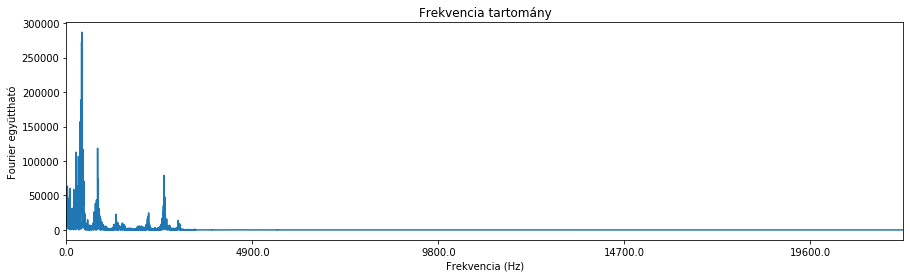

In [126]:
nxlim=10

def sample_to_Hz(ls, lfts, sample_rate, nxlim):
    arr_xticks  = np.linspace(0,lfts,nxlim)
    freq = arr_xticks*sample_rate/ls
    for f in freq:
        f=int(f)
    return freq,arr_xticks


freq,a_x = sample_to_Hz(len(data),len(ftsignal),sample_rate,nxlim)

plt.figure(figsize=(15,4))
plt.plot((ftsignal*np.conjugate(ftsignal)).real)
plt.xticks(a_x,freq)
plt.title("Frekvencia tartomány")
plt.xlabel("Frekvencia (Hz)")
plt.ylabel("Fourier együttható")
plt.xlim(0,10000)


plt.show()

A következőkben a spektrogram implementációm látható. Előszört megcsinálom, majd a következő cellában ábrázolom azt. 
Boxcar módon csináltam. Egy egyszerű ablakkal végigmegyek a jelen, rövid Fourier transzformációkkal kiszámolom adott hosszú jel fouriertranszformáltját, majd átfedéssel továbbhaladok a következő adagra. Úgy korrekt, ha megemlítem, hogy bár saját megértésem szerint írtam és átdolgoztam igényeimnek megfelelően, az alábbi függvényekhez internetes példákat is segítségül vettem.

In [165]:
def make_spectrogram(signal,N_mozgo,N_atfed = -1):

    if N_atfed==-1:
        N_atfed = N_mozgo/2
        
    N_atfed = int(N_atfed)
    kezd  = np.arange(0,len(signal),N_mozgo-N_atfed,dtype=int)

    kezd  = kezd[kezd + N_mozgo < len(signal)] # csak a teljes hosszúságúakat tartom meg
    spx = []
    for i in range(len(kezd)):
        # stdft
        sp_step = DFT(signal[kezd[i]:kezd[i] + N_mozgo]) 
        spx.append(sp_step)
    spx= np.array(spx).T
    
    spx=abs(spx)

    return(kezd,spx)

NMozgo = 256
NAtfed = 128+64
kezd, specgram = make_spectrogram(data,NMozgo,NAtfed)

In [172]:
def plot_spectrogram(spec,a_x,sample_rate, kezd, signal,ftsignal,NMozgo):
    figure(figsize=(20,8))
    spec=sqrt((spec*conjugate(spec)).real)
    
    plt_spec = imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    a_x      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz,asd    = sample_to_Hz(len(signal),len(ftsignal),sample_rate,nxlim)

    
    for i in range(len(ksHz)):
        ksHz[i]=round(ksHz[i])
        
    plt.yticks(a_x,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 5
    ts_spec = linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,len(signal)/sample_rate*kezd[-1]/len(data),Nxticks)]
    xticks(ts_spec,ts_spec_sec)
    xlabel("Time (sec)")

    title("Spectrogram L={} Spectrogram.shape={}".format(NMozgo,spec.shape))
    colorbar(None,use_gridspec=True)
    show()
    return(plt_spec)

A spektrogram csak egyik felének kiplotolása:

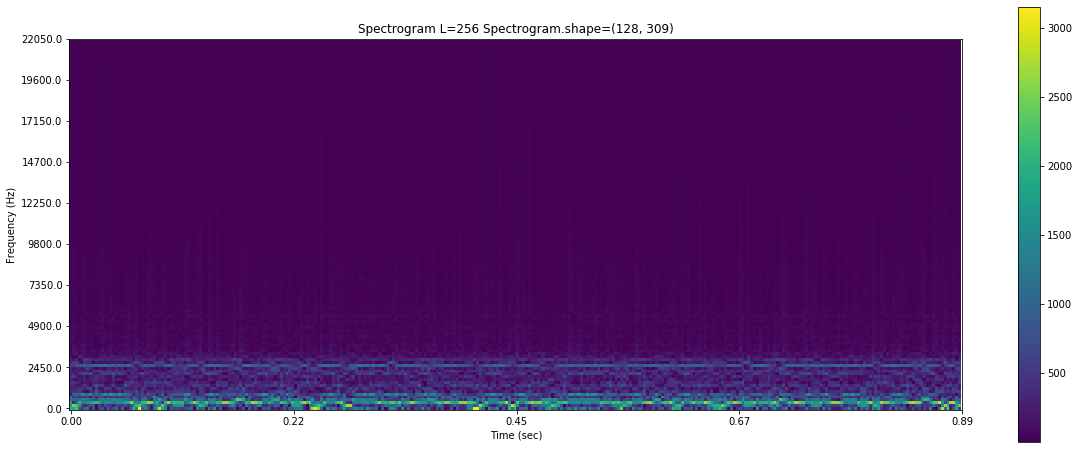

In [173]:
l=int(specgram.shape[0]/2)
newspec=specgram[0:l]
plot_spectrogram(newspec,a_x,int(sample_rate/2),kezd,data,ftsignal,NMozgo)

A spektrogram félbevágása, a két fél összeillesztése, majd ábrázolás:

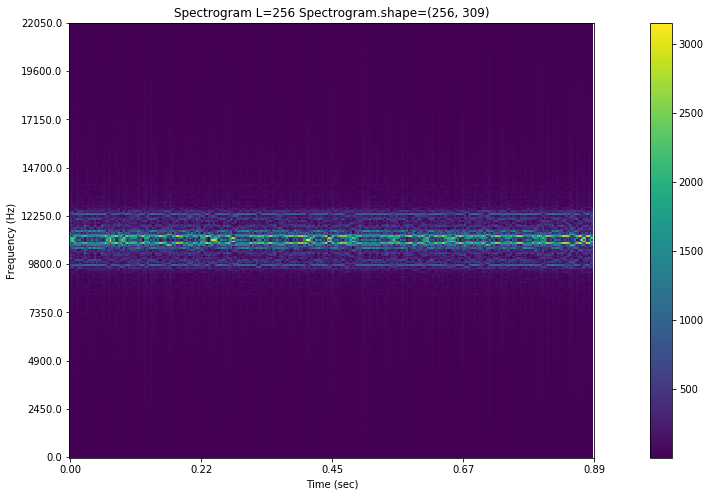

In [174]:
newspec=concatenate((specgram[128:],specgram[0:l]))
plot_spectrogram(newspec,a_x,int(sample_rate/2),kezd,data,ftsignal,NMozgo)

# 2. feladat

Alakítsd át úgy az előző feladat eljárását, hogy frekvenciában ne lineárisan legyenek a osztóközök. Ismerkedj meg a mel skálával, és vesd egybe tapasztalataid az előző feldatatból megismertekkel. 

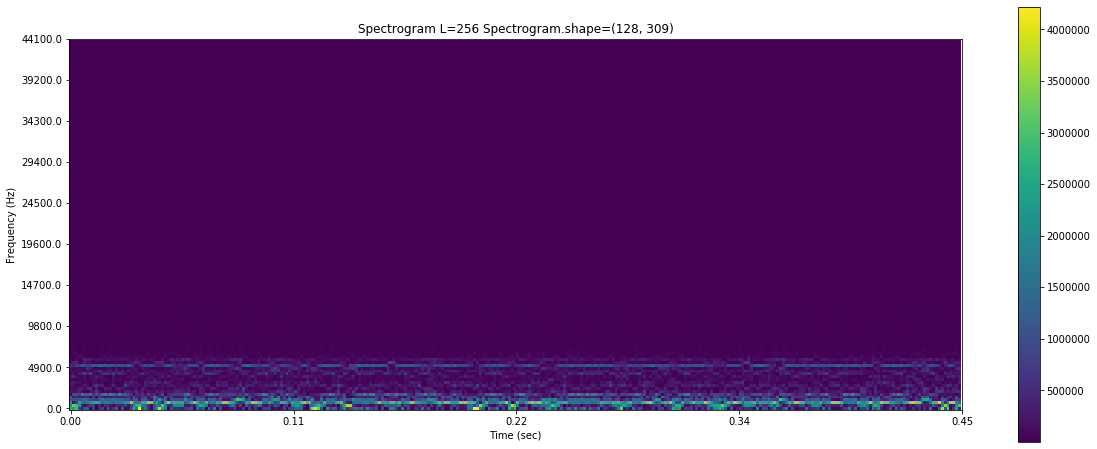

In [169]:
def Hz_to_Mel(spx):
    return 1000/np.log(2)*log(1+spx/1000)
newspec=specgram[0:l]
melspec=Hz_to_Mel(newspec)
plot_spectrogram(melspec,a_x,sample_rate,kezd,data,ftsignal,NMozgo)

# 3. feladat

Próbáld meg elkészíteni azt az eljárást, ami egy _spektrogramból_ állítja elő az eredeti jelet. Mennyire sikerül rekonstruálni az eredeti jelet? Próbálj módosításokat is elvégezni a spektrogramon a jel visszaállítása előtt. Mik a tapasztalataid?

In [132]:
def IDFT(ftsignal):
    signal = []
    L = len(ftsignal)
    ks=np.arange(0,L,1)
    for n in range(L): 
        xn=np.sum(ftsignal*np.exp(-2j*np.pi*ks*n/L))
        signal.append(xn)
    signal=np.array(signal)
    return(signal.real)

In [133]:
signal = IDFT(ftsignal)

Alább látszik, hogy a visszatranszformált jel ugyan olyan, mint az eredeti, tehát a transzformációim jól műkednek. Ez még nem a spektrogramból visszaállított jel.

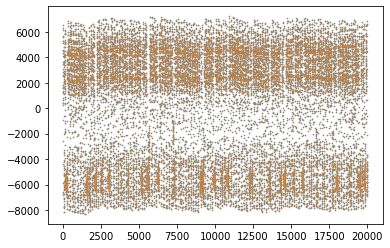

In [134]:
plot(signal,linewidth=0,marker='o', markersize=0.5)
plot(signal,linewidth=0,marker='.', markersize=0.5)
#xlim(0,10000)

Az alálbbiakban visszaalakítom a spektrogramból a jelet. Mivel a jel amit megadtam, egy bonyolultabb, nehezebb jel, látszik, hogy nem nagyon tud mit kezdeni vele a rekonstruáló függvény. De nagyságrendileg értelmes eredményt dob.

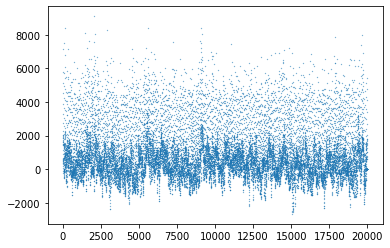

In [176]:
def reconstruct(spx,NMozgo,NAtfed,L):
    #spx=sqrt((spx*conjugate(spx)).real)
    spx=spx.T
    N=L
    rsign=np.zeros(N)
    
    for i in range(len(spx)):
        rs_step=IDFT(spx[i])
        rsign[i*(NMozgo-NAtfed):i*(NMozgo-NAtfed)+len(rs_step)]+=rs_step
    
    return rsign/NMozgo*(NMozgo-NAtfed)
    
    
rsign=reconstruct(specgram,NMozgo,NAtfed,L)


#plot(data,linewidth=0,marker='.', markersize=0.5)
plot(rsign,linewidth=0,marker='.', markersize=0.5)

Azért nem adja vissza szépen a jelet, mert folyamatosan váltakoznak benne a frekvenciák, össze-vissza, az állandóbb jeleket szebben visszaadja az eljárás, ezt lehet látni az alábbi példán.

In [140]:
data.shape

(20000,)

In [141]:
rsign.shape

(20000,)

**A következőkben:**

Megvizsgálok egy egyszerűbb jelet, egy sin függvényt. Ezt átalakítva a spektrogram egy egyszerű vízszintes vonal, erre számítottunk. Visszaalakítva visszakapjuk a szinuszos jelet, persze nem tökéletesen, a két végén főleg nagy az eltérés. 

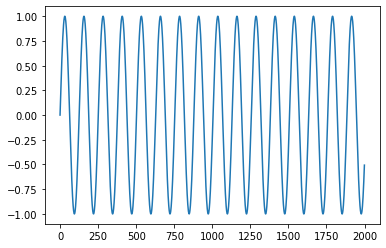

In [189]:
t=linspace(0,100,2000)
data2=sin(t)
L2=len(data2)
plot(data2)

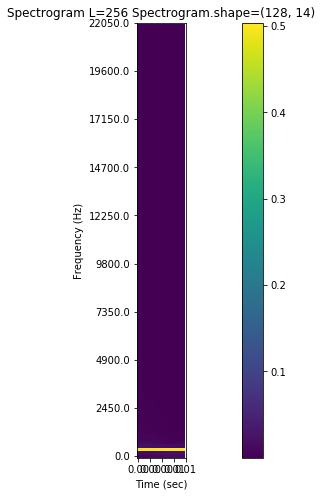

In [190]:
NMozgo2 = 256
NAtfed2 = 128
ftsignal2 = DFT(data2)
kezd2, specgram2 = make_spectrogram(data2,NMozgo2,NAtfed2)
l=int(specgram.shape[0]/2)
newspec2=specgram2[0:l]
plot_spectrogram(newspec2,a_x,int(sample_rate/2),kezd2,data2,ftsignal2,NMozgo2)

In [191]:
ftsignal2 = DFT(data2)
signal2=IDFT(ftsignal2)
print(np.sum(data2**2))
print(np.sum(signal2**2))

1003.9888651575454
1003.9888651575201


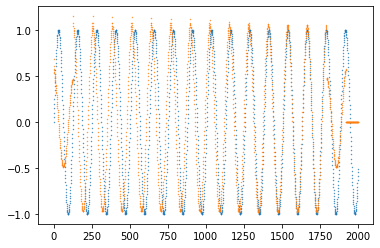

In [192]:
rsign2=reconstruct(specgram2,NMozgo2,NAtfed2,L2)
plot(data2,linewidth=0,marker='.', markersize=0.8)
plot(rsign2,linewidth=0,marker='.', markersize=0.8)

A visszaállított jel teljesítménye, ha nem is egyezik meg az eredetivel, viszonylag közel van hozzá.

In [193]:
print(np.sum(data2**2))
print(np.sum(rsign2*conjugate(rsign2)))

1003.9888651575454
862.7195992803815


Fontos megjegyezni, hogy úgy állítható vissza nagyjából szépen a spektrogramból a jel, ha nem dobjuk el a fázisinformációt. Ha egy tényleges spektrogramot kapnánk, melynél csak a spektrogramhoz ténylegesen szükséges információk vannak megtartva, akkor nem tudnánk visszaállítani a jelet. 